In [9]:
!pip install Munch
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [112]:
from collections import OrderedDict
import re
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
import torch
from munch import Munch
import torch.nn as nn
import torch.nn.functional as F
import einops
from fancy_einsum import einsum
from tqdm.notebook import tqdm
from transformer_lens.HookedTransformer import HookedTransformer, HookedTransformerConfig

sys.path.append('Automatic-Circuit-Discovery/acdc/icl/src') 
from samplers import get_data_sampler
from tasks import get_task_sampler

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
# Select Device:
DEVICE = torch.device('cpu')

### Helper functions

In [114]:
def get_model(path, device="cpu"):
    class PassThroughEmbed(nn.Module):
        def __init__(self, cfg=None):
            super().__init__()
            # No parameters needed, but constructor accepts cfg for compatibility

        def forward(self, tokens):
            # Directly return the input without any modifications
            return tokens

    model = torch.load(path, map_location=DEVICE)
    tl_model = model.to(device)
    tl_model.set_use_attn_result(True)
    tl_model.set_use_split_qkv_input(True)
    if "use_hook_mlp_in" in tl_model.cfg.to_dict():
        tl_model.set_use_hook_mlp_in(True)
    return tl_model

In [115]:
def validation_metric(predictions, labels, return_one_element, device):
    predictions = predictions.to(device)

    loss = (labels - predictions).square().numpy().mean(axis=0)[-5:].mean()
    return loss


In [116]:
def get_data(conf, read_in_weight, read_in_bias, max_len):
    # generate random data (20d points on a gaussian)

    n_dims = conf.model.n_dims
    batch_size = conf.training.batch_size

    data_sampler = get_data_sampler(conf.training.data, n_dims)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **conf.training.task_kwargs
    )
    task = task_sampler()
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end) # should be n_points=conf.training.curriculum.points.end, but has been hacked to work for the max_len of 101 (202)
    ys = task.evaluate(xs)


    # the original model first merges the sequences in z, which we do here (z can have all but the last y since it's causal and intermediate ys are for icl and later icl lenght eval

    batch, n_ctx, d_xs = xs.shape

    ys_wide = torch.cat(
        (
            ys.view(batch, n_ctx, 1),
            torch.zeros(batch, n_ctx, d_xs - 1, device=ys.device),
        ),
        axis=2,
    )
    my_zs = torch.stack((xs, ys_wide), dim=2)
    my_zs = my_zs.view(batch, 2 * n_ctx, d_xs)

    # apply the read_in transformation
    transformed_zs = einsum("batch n_ctx d_xs, d_model d_xs -> batch n_ctx d_model", my_zs, read_in_weight) + read_in_bias

    # apply padding

    current_len = transformed_zs.shape[1]

    pad_len = max(max_len - current_len, 0)

    # Apply padding to the right of the second dimension
    # The padding order in F.pad is (left, right, top, bottom) for 4D input, but here it's the equivalent for 3D
    return F.pad(transformed_zs, (0, 0, 0, pad_len), "constant", 0), ys

## Load parameters of experiment and pretrained model (with embedding parameters)

In [117]:
run_dir = "models"

task = "linear_regression"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)

config_path = os.path.join(run_path, "config.yaml")
with open(config_path) as fp:  # we don't Quinfig it to avoid inherits
    conf = Munch.fromDict(yaml.safe_load(fp))

In [118]:
conf

Munch({'config': 'conf/linear_regression.yaml', 'inherit': ['base.yaml'], 'model': Munch({'family': 'gpt2', 'n_dims': 20, 'n_embd': 256, 'n_head': 8, 'n_layer': 12, 'n_positions': 101}), 'out_dir': '../models/linear_regression', 'test_run': False, 'training': Munch({'batch_size': 64, 'curriculum': Munch({'dims': Munch({'end': 20, 'inc': 1, 'interval': 2000, 'start': 5}), 'points': Munch({'end': 41, 'inc': 2, 'interval': 2000, 'start': 11})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'learning_rate': 0.0001, 'num_tasks': None, 'resume_id': None, 'save_every_steps': 1000, 'task': 'linear_regression', 'task_kwargs': Munch({}), 'train_steps': 500001}), 'wandb': Munch({'entity': 'in-context', 'log_every_steps': 100, 'name': 'linear_regression_pretrained', 'notes': '', 'project': 'in-context-training'})})

In [119]:
model = get_model('hooked_regressor.pt', DEVICE)
read_in_weight = torch.load('read_in_weight.pt', map_location=DEVICE)
read_in_bias = torch.load('read_in_bias.pt', map_location=DEVICE)

Moving model to device:  cpu


In [120]:
def test_model(conf, read_in_weight, read_in_bias, max_len):
    input, labels = get_data(conf, read_in_weight, read_in_bias, max_len)

    with torch.no_grad():
        my_pred = model(input)[:, ::2, 0][:, torch.arange(labels.shape[1])] # this last transformation before returning is in the original and I assume only selects the predictions for ys
    
    mse = validation_metric(my_pred, labels, True, DEVICE)

    return mse

In [121]:
test_model(conf, read_in_weight, read_in_bias, model.cfg.n_ctx)

0.5408128

### Graph

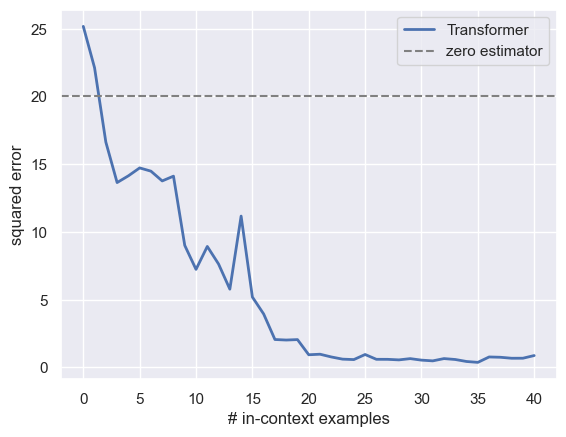

In [77]:
def squared_error(ys_pred, ys):
    return (ys - ys_pred).square()

loss = squared_error(my_pred, labels).numpy()

baseline = {
    "linear_regression": conf.model.n_dims,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [78]:
loss.mean(axis=0)[-5:].mean()

0.75218976